In [174]:
from tqdm import tqdm

import numpy as np
import scipy.sparse as sp
import torch
from torch_geometric.utils import get_laplacian, degree, to_undirected, is_undirected, to_scipy_sparse_matrix
from torch_geometric.datasets import TUDataset
import matplotlib.pyplot as plt

In [125]:
# def compute_commute_times(adj, P=0., to_return=('avg_commute_time',)):

#     adj = to_undirected(adj.type(torch.int64))

#     degrees = degree(adj[0], num_nodes=adj.max()+1)
#     adj_dense = torch.zeros((adj.max()+1, adj.max()+1))
#     adj_dense[adj[0], adj[1]] = 1.

#     prob_mat = (torch.eye(degrees.size(0))-torch.diag(P**degrees)) @ torch.linalg.inv(torch.diag(degrees)) @ adj_dense \
#         + torch.diag(P**degrees)
    
#     laplacian = torch.diag(degrees) @ (torch.eye(prob_mat.size(0)) - prob_mat)
#     laplacian_pinv = torch.linalg.pinv(laplacian)
    
#     laplacian_pinv_diag = torch.diag(laplacian_pinv)
#     commute_times = adj.size(1) * (laplacian_pinv_diag.unsqueeze(0) + laplacian_pinv_diag.unsqueeze(1) - laplacian_pinv - laplacian_pinv.transpose(0, 1))

#     commute_times_flattened = torch.triu(commute_times+1., diagonal=1).flatten()
#     commute_times_filtered = commute_times_flattened[commute_times_flattened > 0.] - 1.
#     avg_commute_time = torch.mean(commute_times_filtered)

#     out = dict()
#     if 'avg_commute_time' in to_return or not to_return:
#         out['avg_commute_time'] = avg_commute_time
#     if 'prob_mat' in to_return:
#         out['prob_mat'] = prob_mat
#     if 'laplacian' in to_return:
#         out['laplacian'] = laplacian
#     if 'commute_times' in to_return:
#         out['commute_times'] = commute_times
#     if 'commute_times_filtered' in to_return:
#         out['commute_times_filtered'] = commute_times_filtered

#     return out

In [160]:
def compute_commute_times(adj, P=0., to_return=('avg_commute_time',)):

    adj = to_undirected(adj.type(torch.int64))

    degrees = degree(adj[0], num_nodes=adj.max()+1)
    adj_dense = torch.zeros((adj.max()+1, adj.max()+1))
    adj_dense[adj[0], adj[1]] = 1.

    prob_mat = (torch.eye(degrees.size(0))-torch.diag(P**degrees)) @ torch.linalg.inv(torch.diag(degrees)) @ adj_dense \
        + torch.diag(P**degrees)
    assert P != 0. or torch.allclose(torch.diag(prob_mat), torch.zeros(prob_mat.size(0)))
    assert torch.allclose(torch.sum(prob_mat, dim=1), torch.ones(prob_mat.size(0)))
    
    coef_mat = (prob_mat - np.eye(prob_mat.size(0)))
    coef_mat[:, -1] = 1.
    inv_coef_mat = torch.linalg.inv(coef_mat)
    stationary_dist = inv_coef_mat[-1]
    
    laplacian = torch.diag(degrees) @ (torch.eye(prob_mat.size(0)) - prob_mat)
    laplacian_pinv = torch.linalg.pinv(laplacian)
    laplacian_pinv_diag = torch.diag(laplacian_pinv)
    
    degreees_div_stat_dist = torch.diag(degrees / stationary_dist).float()
    commute_times = degreees_div_stat_dist @ (laplacian_pinv_diag.unsqueeze(1) - laplacian_pinv.transpose(0, 1)) + \
        (laplacian_pinv_diag.unsqueeze(0) - laplacian_pinv) @ degreees_div_stat_dist
    commute_times_flattened = torch.triu(commute_times+1., diagonal=1).flatten()
    commute_times_filtered = commute_times_flattened[commute_times_flattened > 0.] - 1.
    avg_commute_time = torch.mean(commute_times_filtered)

    out = dict()
    if 'prob_mat' in to_return:
        out['prob_mat'] = prob_mat
    if 'laplacian' in to_return:
        out['laplacian'] = laplacian
    if 'commute_times' in to_return:
        out['commute_times'] = commute_times
    if 'commute_times_filtered' in to_return:
        out['commute_times_filtered'] = commute_times_filtered
    if 'avg_commute_time' in to_return or not to_return:
        out['avg_commute_time'] = avg_commute_time

    return out

In [161]:
adj = torch.Tensor([
    [0, 1],
    [1, 2]
])

result = compute_commute_times(adj, P=0.5, to_return=('commute_times'))
result

{'commute_times': tensor([[ 0.0000,  6.6667, 13.3333],
         [ 6.6667,  0.0000,  6.6667],
         [13.3333,  6.6667,  0.0000]])}

In [162]:
dataset = TUDataset(root='./data', name='Proteins')
len(dataset)

1113

In [163]:
molecule = dataset[0]
result = compute_commute_times(molecule.edge_index, P=0., to_return=('commute_times_filtered', 'avg_commute_times'))

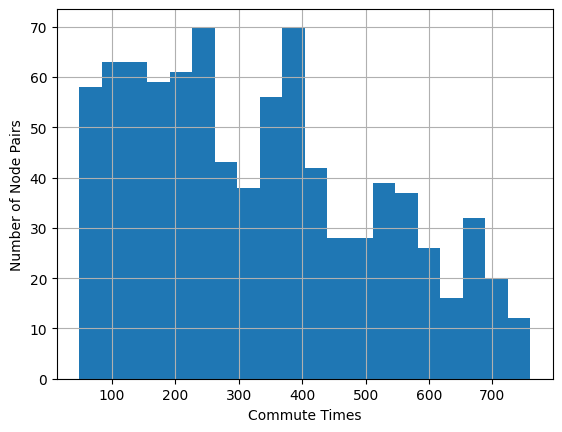

In [164]:
plt.hist(result['commute_times_filtered'], bins=20)
plt.xlabel('Commute Times')
plt.ylabel('Number of Node Pairs')
plt.grid()
plt.show()

In [182]:
import sys

avg_commute_times = list()

for i in range(len(dataset)):
    molecule = dataset[i]
    try:
        result = compute_commute_times(molecule.edge_index)
        avg_commute_times.append(result['avg_commute_time'])
    except:
        print(f'{sys.exc_info()[0].__name__}, i = {i}, ' +
            f'num isolated nodes = {molecule.num_nodes - degree(molecule.edge_index[0]).count_nonzero()}, ' + 
            f"num connected components = {sp.csgraph.connected_components(to_scipy_sparse_matrix(dataset[i].edge_index), connection='strong', return_labels=False)}, " +
            f'num nodes = {molecule.num_nodes}'
        )

_LinAlgError, i = 404, num isolated nodes = 1, num connected components = 2, num nodes = 123
_LinAlgError, i = 645, num isolated nodes = 1, num connected components = 4, num nodes = 56
_LinAlgError, i = 702, num isolated nodes = 1, num connected components = 2, num nodes = 94
_LinAlgError, i = 758, num isolated nodes = 0, num connected components = 9, num nodes = 140
_LinAlgError, i = 989, num isolated nodes = 1, num connected components = 2, num nodes = 20
_LinAlgError, i = 993, num isolated nodes = 1, num connected components = 2, num nodes = 60
_LinAlgError, i = 1008, num isolated nodes = 0, num connected components = 4, num nodes = 57


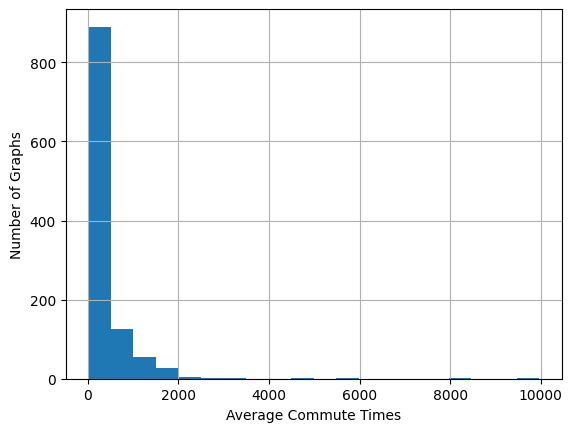

In [73]:
plt.hist(avg_commute_times, bins=20)
plt.xlabel('Average Commute Times')
plt.ylabel('Number of Graphs')
plt.grid()
plt.show()

In [9]:
DROP_P = 0.5

delta_avg_commute_times = list()

for i in range(len(dataset)):

    molecule = dataset[i]

    degrees = degree(molecule.edge_index[0], num_nodes=molecule.num_nodes)
    adj_dense = torch.zeros((molecule.num_nodes, molecule.num_nodes))
    adj_dense[adj[0], adj[1]] = 1.
    
    laplacian = torch.diag(degrees) - adj_dense
    no_drop_avg_commute_time = avg_commute_times(laplacian)
    
    laplacian = laplacian + torch.diag((1-DROP_P) ** degrees) @ adj_dense
    drop_avg_commute_time = avg_commute_times(laplacian)

    delta_avg_commute_times.append((drop_avg_commute_time-no_drop_avg_commute_time)/no_drop_avg_commute_time)

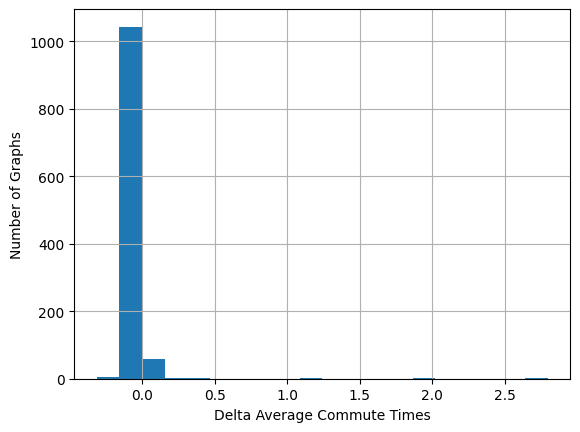

In [10]:
plt.hist(delta_avg_commute_times, bins=20)
plt.xlabel('Delta Average Commute Times')
plt.ylabel('Number of Graphs')
plt.grid()
plt.show()